<a href="https://colab.research.google.com/github/NastyaParnet/evolution/blob/main/Lab6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

10/100 Current population:
((((((x / x) * x) * ((x / x) - (((x - x) - (x / x)) / (x / x)))) - (((x / x) - x) - x)) / (x / x)) * x) = 67.77596000000003
20/100 Current population:
((((((x / x) * x) * ((x / x) - (((x - x) - (x / x)) / (x / x)))) - (((x / x) - x) - x)) / (x / x)) * x) = 67.77596000000003
30/100 Current population:
((((((x / x) * x) * ((x / x) - (x / (x * x)))) - (((x / x) - ((x - x) + (x + x))) - x)) / (x / x)) * x) = 55.18396000000003
40/100 Current population:
((((((x / x) * x) * ((x / x) - (x / (x * x)))) - (((x / x) - ((x - x) + (x + x))) - x)) / (x / x)) * x) = 55.18396000000003
50/100 Current population:
((((((x / x) * x) * ((x / x) - (x / (x * x)))) - (((x / x) - ((x - x) + (x + x))) - x)) - (x / x)) * x) = 42.591959999999986
60/100 Current population:
((((((x / x) * x) * ((x / x) - ((x + x) / (x * x)))) - ((((x + x) / x) - ((x - x) + (x + x))) - x)) - (x / x)) * x) = 17.407959999999996
70/100 Current population:
((((((x / x) * x) * ((x / x) - ((x + x) / (x * x)))) 

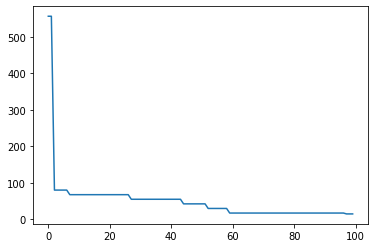

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def fitness(x):
    return (x * x) + (x * x) - (x + x)


class GEP(object):
    def __init__(self, grammar, bounds, len_head, iterations, pop_size, prob_crossover):
        self.grammar = grammar
        self.bounds = bounds
        self.len_head = len_head
        self.len_tail = len_head * (len(grammar['TERM'])) + 1
        self.iterations = iterations
        self.pop_size = pop_size
        self.prob_crossover = prob_crossover
        self.population = [Individual(self.random_genome()) for _ in range(self.pop_size)]
        self.best = sorted(self.population, key=lambda x: x.fitness)[0]

    def binary_tournament(self):
        a, b = np.random.choice(self.population, 2)
        return a if a.fitness < b.fitness else b

    def point_mutation(self, genome):
        rate = 1.0 / len(genome)
        child = list()
        for i in range(len(genome)):
            bit = genome[i]
            if np.random.random() < rate:
                if i < self.len_head:
                    selection = self.grammar['FUNC'] if np.random.random() < 0.5 else self.grammar['TERM']
                    bit = selection[np.random.randint(0, len(selection))]
                else:
                    bit = self.grammar['TERM'][np.random.randint(0, len(self.grammar['TERM']))]
            child.append(bit)
        return ''.join(child)

    def crossover(self, parent1, parent2):
        if np.random.random() < self.prob_crossover:
            return ''.join([a if np.random.random() < 0.5 else b for a, b in zip(parent1, parent2)])
        else:
            return parent1

    def reproduce(self, selected):
        children = list()
        for a, b in zip(selected[::2], selected[1::2]):
            children.append(Individual(self.point_mutation(self.crossover(a.genome, b.genome))))
        return children

    def random_genome(self):
        s = list()
        for _ in range(self.len_head):
            selection = self.grammar['FUNC'] if np.random.random() < 0.5 else self.grammar['TERM']
            s.append(selection[np.random.randint(0, len(selection))])
        for _ in range(self.len_tail):
            s.append(self.grammar['TERM'][np.random.randint(0, len(self.grammar['TERM']))])
        return ''.join(s)

    def cost(program):
        errors = 0.0
        for x, y in TABLE:
            expression = program.replace('x', str(x))
            try:
                score = eval(expression)
            except ZeroDivisionError:
                score = float('inf')
            errors += abs(score - y)
        if np.isnan(errors):
            errors = float('inf')
        return errors / len(TABLE)

    def mapping(genome):
        off = 0
        queue = list()
        root = {'node': genome[off]}
        off += 1
        queue.append(root)
        while len(queue) > 0:
            current = queue.pop(0)
            if current['node'] in GRAMMAR['FUNC']:
                current['left'] = {'node': genome[off]}
                off += 1
                queue.append(current['left'])
                current['right'] = {'node': genome[off]}
                off += 1
                queue.append(current['right'])
        return root

    def tree_to_string(exp):
        if 'left' not in exp or 'right' not in exp:
            return exp['node']
        left = GEP.tree_to_string(exp['left'])
        right = GEP.tree_to_string(exp['right'])
        if exp['node'] in ['+', '-', '*', '/']:
            return '({0} {1} {2})'.format(left, exp['node'], right)
        else:
            func = {
                'P': 'np.power',
            }.get(exp['node'], None)
            return '({0}({1}, {2}))'.format(func, left, right)

    def run(self):
        plotY = []
        for gen in range(1, self.iterations + 1):
            selected = [self.binary_tournament() for _ in range(self.pop_size)]
            children = self.reproduce(selected)
            children = list(sorted(children, key=lambda x: x.fitness))
            self.best = children[0] if children[0].fitness <= self.best.fitness else self.best
            self.population = sorted((children + self.population), key=lambda x: x.fitness)[:self.pop_size]
            plotY.append(self.best.fitness)
            if gen % 10 == 0:
                print('{0}/{1} Current population:'.format(gen, self.iterations))
                print(self.best)
            if self.best.fitness == 0.0:
                print('{0}/{1} Current population:'.format(gen, self.iterations))
                print(self.best)
                break
        plt.plot(plotY)
        plt.show()
        return self.best


class Individual(object):
    def __init__(self, genome):
        self.genome = genome
        self.expression = GEP.mapping(genome)
        self.program = GEP.tree_to_string(self.expression)
        self.fitness = GEP.cost(self.program)

    def __str__(self):
        return '{0} = {1}'.format(self.program, self.fitness)


GRAMMAR = {'FUNC': ['+', '-', '*', '/'], 'TERM': ['x']}
BOUNDS = [1.0, 26.0]
TABLE = [
    [3.4, 2.64],
    [5.4, 65.04],
    [6.7, 122.76],
    [8.2, 206.16],
    [9.12, 266.2176],
    [10.25, 349.25],
    [12.34, 529.7424],
    [21.43, 1721.26],
    [23.76, 2133.11],
    [25.32, 2433.13]
]
LEN_HEAD = 30
ITERATIONS = 100
POP_SIZE = 100
PROB_CROSS = 0.85


def main():
    gep = GEP(GRAMMAR, BOUNDS, LEN_HEAD, ITERATIONS, POP_SIZE, PROB_CROSS)
    gep.run()

if __name__ == '__main__':
    main()

In [ ]:
def f(x):
  return  (((x + ((x + x) / (x / (x - ((((((x + x) / x) - ((x - x) - x)) + (((x / x) + x) + (x / x))) + x) / x))))) + x) * x) # 4 * x * x + 3 * x + 4

print("f(10) = ", f(10))
print("f(20) = ", f(20))
print("f(30) = ", f(30))

f(10) =  332.0
f(20) =  1472.0
f(30) =  3412.0000000000005
